In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


In [3]:
## =====================================================
# 1. Data inlezen en voorbereiden
# =====================================================
file_path = r"C:\Users\TurkmenBersu\OneDrive - PostNL\Analyse betrokkenheidsmonitor\ruwedatawbscumq2q3.xlsx"

def load_data(file_path: str):

    """
    Laadt de Excel, fixt de headers en maakt:
    - df: volledige dataset
    - df_genx: alleen Generatie X
    - df_nonx: alle andere generaties
    - questions_full: lijst kolomnamen (incl. Betrokkenheid)
    - labels_full: korte labelnamen (voor de Y-as)
    """

    # Header-fix
    header_rows = pd.read_excel(file_path, sheet_name="Data Bewerkt", nrows=2, header=None)
    h0 = header_rows.iloc[0].tolist()
    h1 = header_rows.iloc[1].tolist()

    for i in range(36, 49):  # AK..AX
        h1[i] = h0[i]

    df = pd.read_excel(file_path, sheet_name="Data Bewerkt", header=1)
    df.columns = h1

    generation_col = "Crossing: Generatie"

    # Vraagkolommen
    questions_orig = list(df.columns[36:49])
    questions_short = [
        "Gevoel te passen","Energie","Plezier","Trots",
        "Informatie toekomstplannen","Bijdragen aan toekomstplannen",
        "Waardering voor de bijdrage","Werkdruk (goed)",
        "Klantgerichtheid","Luisteren",
        "Ideeën en voorstellen gebruiken","Uitleg keuzes","eNPS (aanbeveling)"
    ]

    for q in questions_orig:
        df[q] = pd.to_numeric(df[q], errors="coerce")

    # Dienstjaren samenvatten
    dienstjaren_mapping = {
        "Tot 2 jaar": "<2", "0-2": "<2",
        "2 tot 5 jaar": "2-5", "2-5": "2-5",
        "5 tot 10 jaar": "5-10", "5-10": "5-10",
        "10 tot 20 jaar": "10-20", "10-20": "10-20",
        "20 tot 30 jaar": "20-30", "20-30": "20-30",
        "30 tot 40 jaar": "30-40", "30-40": "30-40",
        "Vanaf 40 jaar": "40+", "40+": "40+",
    }

    df["Dienstjarengroep_samengevat"] = (
        df["Dienstjarengroep"].replace(dienstjaren_mapping).fillna(df["Dienstjarengroep"])
    )

    valid = df.dropna(subset=[generation_col, "Dienstjarengroep_samengevat"])
    is_genx = valid[generation_col].astype(str).str.contains("X", case=False, na=False)

    df_genx = valid[is_genx].copy()
    df_nonx = valid[~is_genx].copy()

    # Samengestelde Betrokkenheid
    four_keys = [
        "Ik heb het gevoel dat ik bij PostNL pas",
        "Mijn werk geeft mij energie",
        "Ik heb plezier in mijn werk",
        "Ik ben trots op PostNL",
    ]

    valid["Betrokkenheid (gem)"]   = valid[four_keys].mean(axis=1, skipna=True)
    df_genx["Betrokkenheid (gem)"] = df_genx[four_keys].mean(axis=1, skipna=True)
    df_nonx["Betrokkenheid (gem)"] = df_nonx[four_keys].mean(axis=1, skipna=True)

    questions_full = ["Betrokkenheid (gem)"] + questions_orig
    labels_full    = ["Betrokkenheid"]       + questions_short

    return df, df_genx, df_nonx, questions_full, labels_full

In [4]:
df, df_genx, df_nonx, questions_full, labels_full = load_data(file_path)
df.head  # werkt nu wel


<bound method NDFrame.head of        Participant ID Uitgenodigd  Response aantal vragen Responent  \
0            36394556          Ja                      12     Deels   
1            36399119          Ja                      13        Ja   
2            36404888          Ja                      13        Ja   
3            36394597          Ja                      12     Deels   
4            36401280          Ja                      13        Ja   
...               ...         ...                     ...       ...   
21059        36416565          Ja                       0       Nee   
21060        36414756          Ja                       0       Nee   
21061        36415214          Ja                       0       Nee   
21062        36418687          Ja                       0       Nee   
21063        41395315          Ja                       0       Nee   

      Characteristic 1                     Characteristic 2  \
0                    1  51000478 - Mail (Staven & Serv

In [25]:
def analyse_dienstjaren(df_genx, df_nonx, questions_full):
    """
    Retourneert:
    - delta_disp: DataFrame met Δ% (Gen X – Niet-Gen X) per dienstjaren x vraag
    - sig: boolean-masker van significante cellen (FDR < 0.05)
    - groups_order: volgorde van dienstjarengroepen
    """

    groups_order = ["<2", "2-5", "5-10", "10-20", "20-30", "30-40", "40+"]

    means_nonx = (
        df_nonx.groupby("Dienstjarengroep_samengevat")[questions_full]
        .mean()
        .reindex(groups_order)
    )

    means_genx = (
        df_genx.groupby("Dienstjarengroep_samengevat")[questions_full]
        .mean()
        .reindex(groups_order)
    )

    # ruwe Δ (1–5-schaal)
    delta = means_nonx - means_genx

    # Welch t-tests
    pvals = pd.DataFrame(index=groups_order, columns=questions_full, dtype=float)

    valid = pd.concat([df_genx, df_nonx], axis=0)
    present_groups = valid["Dienstjarengroep_samengevat"].dropna().unique().tolist()

    for g in groups_order:
        if g not in present_groups:
            continue

        a_nonx = df_nonx[df_nonx["Dienstjarengroep_samengevat"] == g]
        a_genx = df_genx[df_genx["Dienstjarengroep_samengevat"] == g]

        for q in questions_full:
            va = pd.to_numeric(a_nonx[q], errors="coerce").dropna()
            vx = pd.to_numeric(a_genx[q], errors="coerce").dropna()

            if len(va) > 2 and len(vx) > 2:
                _, p = ttest_ind(vx, va, equal_var=False, nan_policy="omit")
                pvals.loc[g, q] = p

    # FDR-correctie
    flat = pvals.values.ravel()
    mask = ~np.isnan(flat)
    corr = np.full_like(flat, np.nan)

    if mask.sum() > 0:
        _, corr_vals, _, _ = multipletests(flat[mask], method="fdr_bh", alpha=0.05)
        corr[mask] = corr_vals

    pvals_corr = corr.reshape(pvals.shape)

    # Δ naar % schaal (1–5)
    Z_pct = (delta.values / 4.0) * 100.0

    sig = (pvals_corr < 0.05)
    sig = np.nan_to_num(sig, nan=False)

    delta_disp = pd.DataFrame(Z_pct, index=groups_order, columns=questions_full)

    return delta_disp, sig, groups_order


In [28]:
delta_disp, sig, groups_order = analyse_dienstjaren(df_genx, df_nonx, questions_full)
print(delta_disp, sig, groups_order)

       Betrokkenheid (gem)  Ik heb het gevoel dat ik bij PostNL pas  \
<2                2.673978                                 2.402458   
2-5               2.377978                                 1.408617   
5-10             -0.337093                                -1.969623   
10-20            -2.167416                                -2.911255   
20-30            -3.366599                                -2.940626   
30-40            -3.917946                                -3.349508   
40+                    NaN                                      NaN   

       Mijn werk geeft mij energie  Ik heb plezier in mijn werk  \
<2                        6.475751                     3.904424   
2-5                       5.951041                     4.705467   
5-10                      1.702587                     1.588435   
10-20                     1.151929                     0.430427   
20-30                    -1.188258                    -2.699715   
30-40                    -5.1

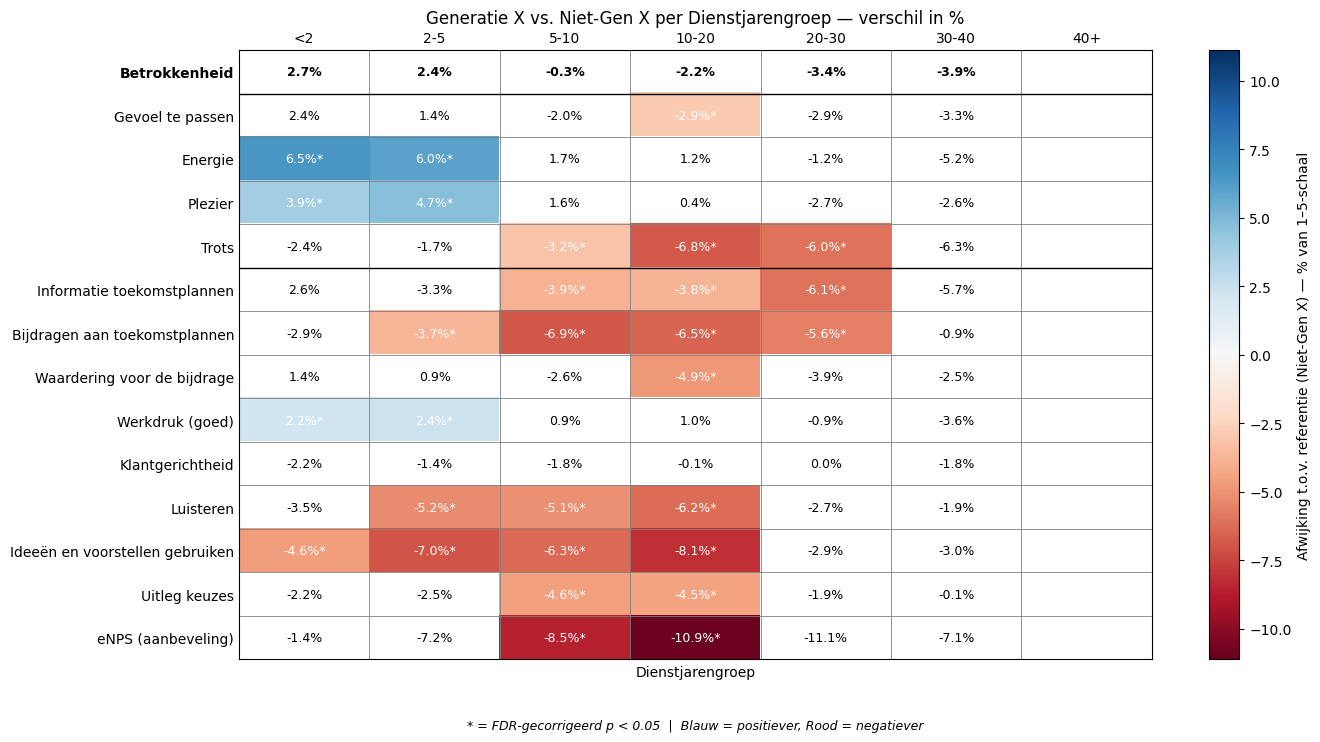

In [29]:
plot_dienstjaren_heatmap(delta_disp, sig, labels_full)

In [8]:
# =====================================================
# 4. Analyse hoofdeffect (zonder dienstjaren)
# =====================================================

def analyse_hoofdeffect(df_genx, df_nonx, questions_full):
    """
    Retourneert:
    - delta_main_pct: Series met Δ% per vraag (Gen X – Niet-Gen X)
    - sig_main: boolean-array met significantie (FDR < 0.05)
    """

    means_genx = df_genx[questions_full].mean()
    means_nonx = df_nonx[questions_full].mean()

    delta_main = means_nonx - means_genx

    # Welch t-test per vraag
    pvals_main = []
    for q in questions_full:
        gvals = pd.to_numeric(df_genx[q], errors="coerce").dropna()
        nvals = pd.to_numeric(df_nonx[q], errors="coerce").dropna()

        if len(gvals) > 2 and len(nvals) > 2:
            _, p = ttest_ind(gvals, nvals, equal_var=False, nan_policy="omit")
            pvals_main.append(p)
        else:
            pvals_main.append(np.nan)

    pvals_main = np.array(pvals_main)
    mask = ~np.isnan(pvals_main)

    pvals_corr_main = np.full_like(pvals_main, np.nan)
    if mask.sum() > 0:
        _, corr_main, _, _ = multipletests(
            pvals_main[mask], method="fdr_bh", alpha=0.05
        )
        pvals_corr_main[mask] = corr_main

    delta_main_pct = (delta_main / 4.0) * 100.0
    sig_main = pvals_corr_main < 0.05

    return delta_main_pct, sig_main


In [9]:
delta_main_pct, sig_main = analyse_hoofdeffect(df_genx, df_nonx, questions_full)

In [10]:
print(delta_main_pct)
print(sig_main)

Betrokkenheid (gem)                                                                                           -3.078532
Ik heb het gevoel dat ik bij PostNL pas                                                                       -2.543146
Mijn werk geeft mij energie                                                                                   -0.581646
Ik heb plezier in mijn werk                                                                                   -1.051125
Ik ben trots op PostNL                                                                                        -8.105087
Ik word voldoende geïnformeerd over de toekomstplannen van PostNL                                             -4.738967
Ik vind dat mijn werk bijdraagt aan het behalen van de toekomstplannen van PostNL                             -5.203349
Ik voel mij gewaardeerd voor de bijdrage die ik lever                                                         -4.275152
Ik vind mijn werkdruk                   

In [11]:
# =====================================================
# 5. Plot hoofdeffect-heatmap (1 kolom)
# =====================================================

def plot_hoofdeffect_heatmap(delta_main_pct, sig_main, labels_full, title_suffix=""):
    """
    Maakt een 1-koloms heatmap:
    - X: "Gen X vs Niet-Gen X"
    - Y: vragen incl. Betrokkenheid
    """

    Z = delta_main_pct.values.reshape(1, -1)
    sig_mask = sig_main.reshape(1, -1)

    fig, ax = plt.subplots(figsize=(5, 8))

    cmap = plt.get_cmap("RdBu").copy()
    absmax = np.nanmax(np.abs(Z)) if np.isfinite(Z).any() else 1
    norm = TwoSlopeNorm(vmin=-absmax, vcenter=0, vmax=absmax)

    Z_color = np.ma.array(Z, mask=~sig_mask)
    im = ax.imshow(
        Z_color.T,
        cmap=cmap,
        norm=norm,
        aspect="auto",
        origin="upper",
        interpolation="none"
    )

    n_cols = len(labels_full)

    # Geen automatische gridlines
    ax.grid(False)
    ax.tick_params(which="both", length=0)

    # Grenzen tussen rijen
    for y in range(n_cols + 1):
        ax.plot([-0.5, 0.5], [y - 0.5, y - 0.5], color="gray", linewidth=0.6)

    # Tekst
    for i, val in enumerate(delta_main_pct.values):
        if np.isfinite(val):
            is_sig = sig_main[i]
            text_color = "white" if is_sig else "black"
            txt = f"{val:.1f}%" + ("*" if is_sig else "")
            weight = "bold" if i == 0 else "normal"  # Betrokkenheid vet

            ax.text(
                0, i, txt,
                ha="center", va="center",
                color=text_color,
                fontsize=9,
                fontweight=weight
            )

    ax.set_xticks([0])
    ax.set_xticklabels(["Gen X vs. Niet-Gen X"])

    ax.set_yticks(np.arange(n_cols))
    ax.set_yticklabels(labels_full)

    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Betrokkenheid-label vet
    ax.get_yticklabels()[0].set_fontweight("bold")

    # Lijn onder Betrokkenheid
    ax.plot([-0.5, 0.5], [0.5, 0.5], color="black", linewidth=1.0)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Afwijking t.o.v. referentie (Niet-Gen X) — % van 1–5-schaal")

    titel = "Generatie X vs. Niet-Gen X — hoofdeffect per vraag"
    if title_suffix:
        titel += f" ({title_suffix})"

    ax.set_title(titel)
    ax.set_xlabel("")
    ax.set_ylabel("")

    fig.text(
        0.5, -0.03,
        "* = FDR-gecorrigeerd p < 0.05  |  Blauw = positiever, Rood = negatiever",
        ha="center", fontsize=9, style="italic"
    )

    plt.tight_layout()
    plt.show()

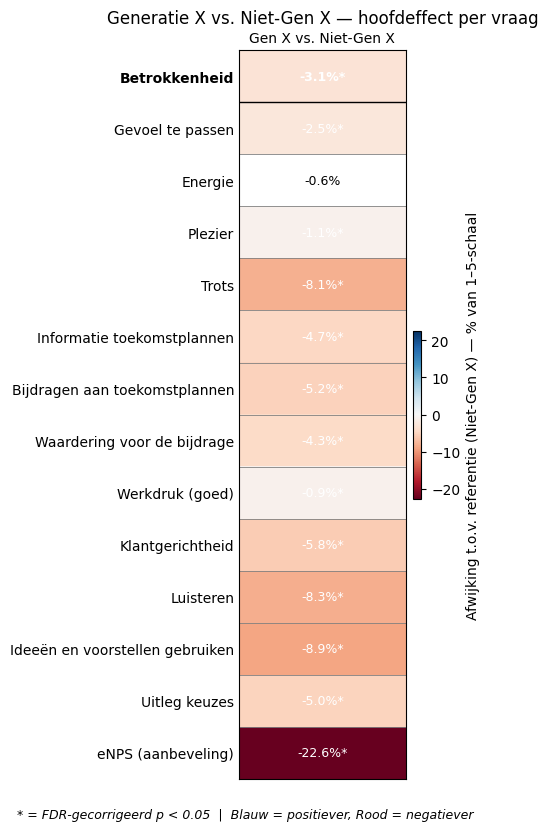

In [12]:
plot_hoofdeffect_heatmap(delta_main_pct, sig_main, labels_full)